In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

## 2.

### Prepare data for each gate

In [2]:
# Define the truth tables for the gates
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_and = np.array([0, 0, 0, 1])
y_or = np.array([0, 1, 1, 1])
y_xor = np.array([0, 1, 1, 0])
y_nand = np.array([1, 1, 1, 0])

### Create models

In [3]:
# Initialize models
logistic_regression = LogisticRegression()
svc = SVC() # rbf as kernel default

### Train the models 

In [4]:
# Train and evaluate models for each gate
results = {}
for gate_name, y in zip(['AND', 'OR', 'XOR', 'NAND'], [y_and, y_or, y_xor, y_nand]):
    # Train Logistic Regression
    logistic_regression.fit(X, y)
    y_pred_lr = logistic_regression.predict(X)
    accuracy_lr = accuracy_score(y, y_pred_lr)

    # Train SVC
    svc.fit(X, y)
    y_pred_svc = svc.predict(X)
    accuracy_svc = accuracy_score(y, y_pred_svc)

    # Store results
    results[gate_name] = {
        'Logistic Regression': {'predictions': y_pred_lr, 'accuracy': accuracy_lr},
        'SVC': {'predictions': y_pred_svc, 'accuracy': accuracy_svc}
    }


In [5]:
print(results)

{'AND': {'Logistic Regression': {'predictions': array([0, 0, 0, 0]), 'accuracy': 0.75}, 'SVC': {'predictions': array([0, 0, 0, 1]), 'accuracy': 1.0}}, 'OR': {'Logistic Regression': {'predictions': array([1, 1, 1, 1]), 'accuracy': 0.75}, 'SVC': {'predictions': array([0, 1, 1, 1]), 'accuracy': 1.0}}, 'XOR': {'Logistic Regression': {'predictions': array([0, 0, 0, 0]), 'accuracy': 0.5}, 'SVC': {'predictions': array([0, 1, 1, 0]), 'accuracy': 1.0}}, 'NAND': {'Logistic Regression': {'predictions': array([1, 1, 1, 1]), 'accuracy': 0.75}, 'SVC': {'predictions': array([1, 1, 1, 0]), 'accuracy': 1.0}}}


* Logistic Regression: This model struggles with these logic gates because it is a linear model and tends to predict the majority class, especially in imbalanced datasets. It cannot capture the non-linear relationships required for gates like XOR. 
* SVC with RBF Kernel: This model performs perfectly for all gates because the RBF kernel can capture non-linear patterns, which is crucial for learning the behavior of gates like XOR and NAND

## 3.

### Create 2000 random imbalanced data

In [6]:
# Function to generate synthetic data based on class ratio and return it
def generate_synthetic_data(class_ratio, n_samples=1000):
    X, y = make_classification(n_samples=n_samples, n_features=20, n_informative=2, n_redundant=10,
                               n_clusters_per_class=1, weights=[class_ratio, 1-class_ratio], flip_y=0, random_state=42)
    return X, y

### Create PR and ROC graph

In [9]:
# Function to generate synthetic data and plot ROC and Precision-Recall curves
def plot_roc_pr_curves(class_ratio, n_samples=1000):
    # Generate synthetic data
    X, y = generate_synthetic_data(class_ratio, n_samples)
    
    # Train a logistic regression classifier
    clf = LogisticRegression().fit(X, y)
    
    # Predict probabilities
    y_scores = clf.predict_proba(X)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y, y_scores)
    
    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y, y_scores)
    
    # Plot ROC curve
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (Class ratio {class_ratio:.2f}/{1-class_ratio:.2f})')
    plt.legend()
    
    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (Class ratio {class_ratio:.2f}/{1-class_ratio:.2f})')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Plot 50/50

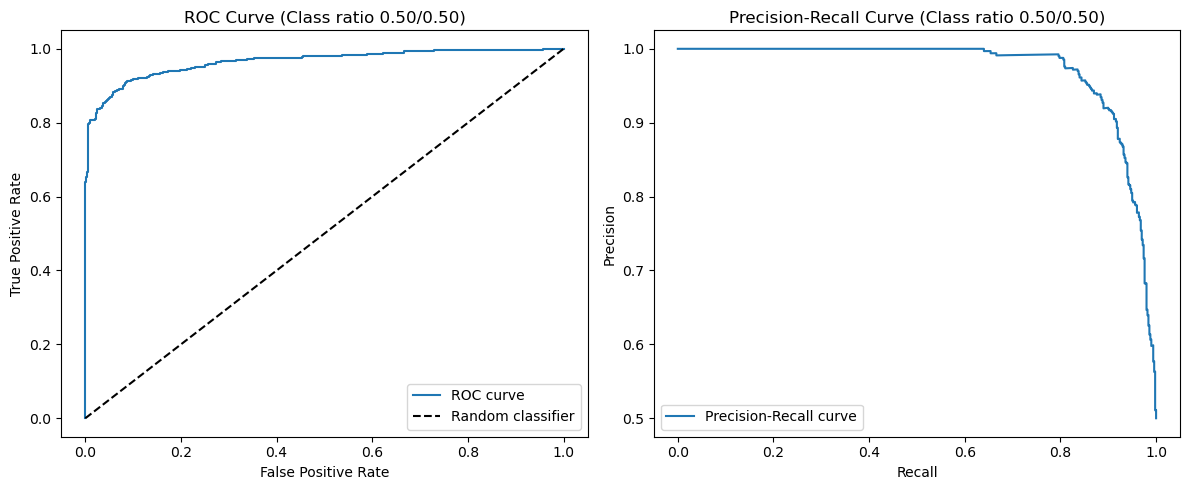

In [11]:
plot_roc_pr_curves(0.5)

### Plot 75/25

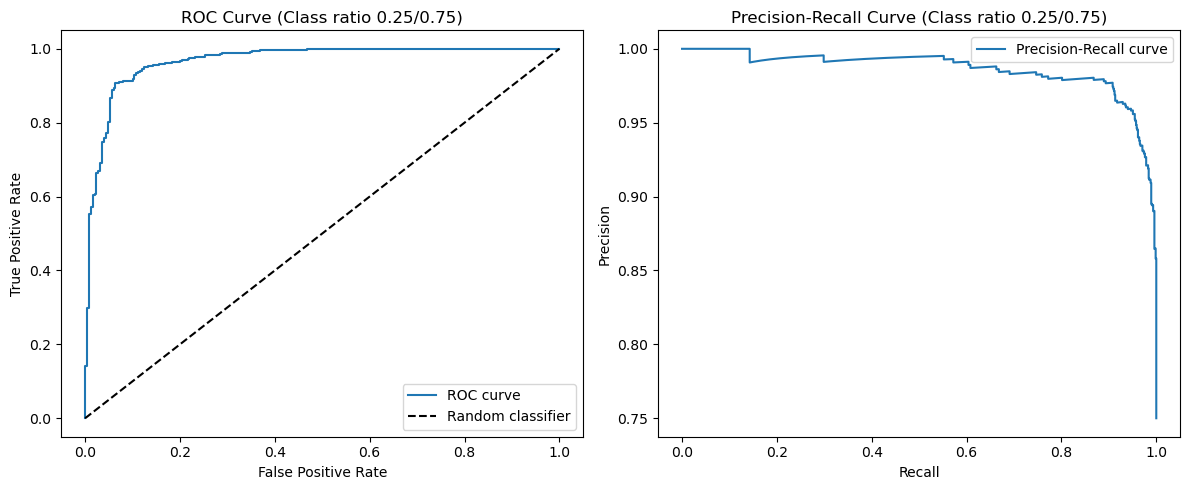

In [12]:
plot_roc_pr_curves(0.25)

### Plot 10/90

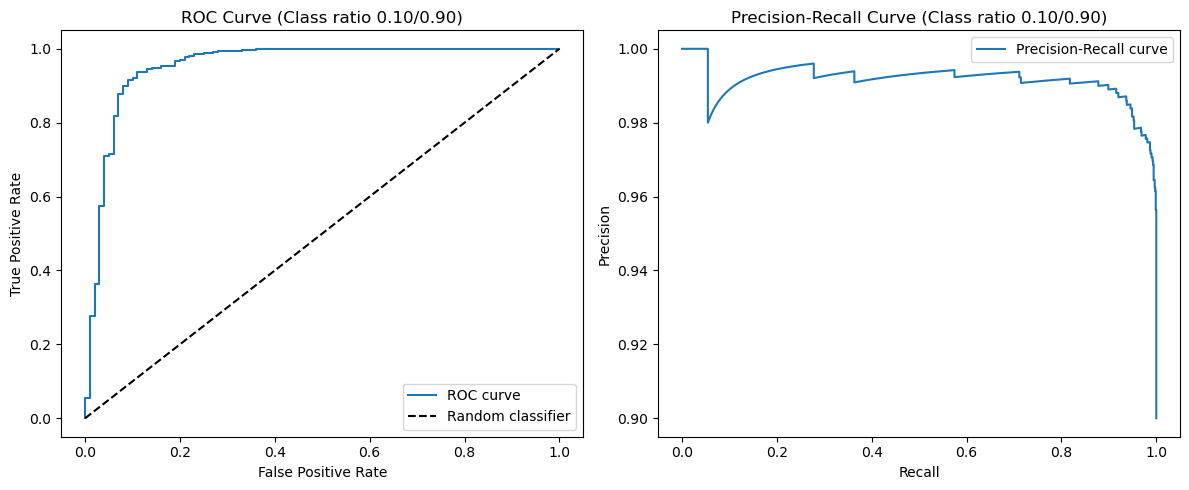

In [13]:
plot_roc_pr_curves(0.1)

* The ROC curve shows the trade-off between the true positive rate (TPR) and the false positive rate (FPR) at various threshold settings.It remains relatively stable across different class imbalances because it takes both TPR and FPR into account.
* The PR curve focuses on the trade-off between precision (positive predictive value) and recall (sensitivity) for the positive class. As the class imbalance increases, the PR curve becomes more informative, highlighting the classifier's performance on the minority class. As demonstrated in graph with threshhold 10/90, the PR curve is fluctuate around 0.1.
* 50/50 ROC Curve: Preferred because it provides a balanced view of performance across all thresholds, accounting for both false positives and false negatives
* 75/25, 90/10 PR Curve: Preferred because it provides a clearer picture of performance for the minority class, which is often of primary interest. It highlights the classifier's ability to identify positive instances without being overly influenced by the abundance of negative instances. If AUC is introduced to both cases, the AUC metric would be more helpful to determine model's performance
* In real world scenario, consider a medical diagnosis system for a rare disease, where the number of patients with the disease (positive class) is much smaller compared to healthy individuals (negative class). The dataset is thus highly imbalanced.The Precision-Recall curve is preferred in this scenario because it provides a clearer picture of how well the classifier can identify patients with the disease. High precision ensures that when the model predicts the presence of the disease, it is likely correct, reducing the risk of false positives which could lead to unnecessary stress and treatment. High recall ensures that most of the actual disease cases are identified, which is critical in a medical context to provide timely treatment.

## 4.

### Create dataset

In [20]:
# Function to generate California Housing dataset from sklearn
def load_california_housing():
    housing = fetch_california_housing()
    X = housing.data
    y = housing.target
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Function to add noise to the dataset
def add_noise(y, noise_level=0.1):
    noise = noise_level * np.random.randn(*y.shape)
    return y + noise

### Create model 

In [22]:
# Function to create a neural network model
def create_model(input_dim, hidden_units=[10]):
    model = {}
    model['W1'] = tf.Variable(tf.random.normal([input_dim, hidden_units[0]]))
    model['b1'] = tf.Variable(tf.random.normal([hidden_units[0]]))
    if len(hidden_units) > 1:
        model['W2'] = tf.Variable(tf.random.normal([hidden_units[0], hidden_units[1]]))
        model['b2'] = tf.Variable(tf.random.normal([hidden_units[1]]))
    model['W_out'] = tf.Variable(tf.random.normal([hidden_units[-1], 1]))
    model['b_out'] = tf.Variable(tf.random.normal([1]))
    return model

In [23]:
# Function to forward propagate
def forward_pass(model, X):
    Z1 = tf.add(tf.matmul(X, model['W1']), model['b1'])
    A1 = tf.nn.relu(Z1)
    if 'W2' in model:
        Z2 = tf.add(tf.matmul(A1, model['W2']), model['b2'])
        A2 = tf.nn.relu(Z2)
        output = tf.add(tf.matmul(A2, model['W_out']), model['b_out'])
    else:
        output = tf.add(tf.matmul(A1, model['W_out']), model['b_out'])
    return output

In [24]:
# Function to compute loss
def compute_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [25]:
# Function to train the model
def train_model(model, X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=100):
    optimizer = tf.optimizers.Adam(learning_rate)
    train_loss_history = []
    test_loss_history = []

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            y_pred_train = forward_pass(model, X_train)
            train_loss = compute_loss(y_train, y_pred_train)

        gradients = tape.gradient(train_loss, list(model.values()))
        optimizer.apply_gradients(zip(gradients, list(model.values())))

        y_pred_test = forward_pass(model, X_test)
        test_loss = compute_loss(y_test, y_pred_test)

        train_loss_history.append(train_loss.numpy())
        test_loss_history.append(test_loss.numpy())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss = {train_loss.numpy()}, Test Loss = {test_loss.numpy()}')

    return train_loss_history, test_loss_history

### Plot the graph

In [27]:
# Function to plot results
def plot_results(y_test, y_pred, train_loss_history, test_loss_history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, label='Predicted Values')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Ideal Fit')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.title('True vs Predicted Values')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(test_loss_history, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.tight_layout()
    plt.show()

### Train an initial model

Epoch 0: Train Loss = 118.64836883544922, Test Loss = 121.87015533447266
Epoch 10: Train Loss = 110.23519134521484, Test Loss = 111.37163543701172
Epoch 20: Train Loss = 106.27173614501953, Test Loss = 106.92396545410156
Epoch 30: Train Loss = 105.11481475830078, Test Loss = 105.82022857666016
Epoch 40: Train Loss = 104.55347442626953, Test Loss = 105.216552734375
Epoch 50: Train Loss = 104.0272216796875, Test Loss = 104.62281036376953
Epoch 60: Train Loss = 103.696533203125, Test Loss = 104.27241516113281
Epoch 70: Train Loss = 103.47257995605469, Test Loss = 104.03455352783203
Epoch 80: Train Loss = 103.31318664550781, Test Loss = 103.85468292236328
Epoch 90: Train Loss = 103.19053649902344, Test Loss = 103.7182846069336


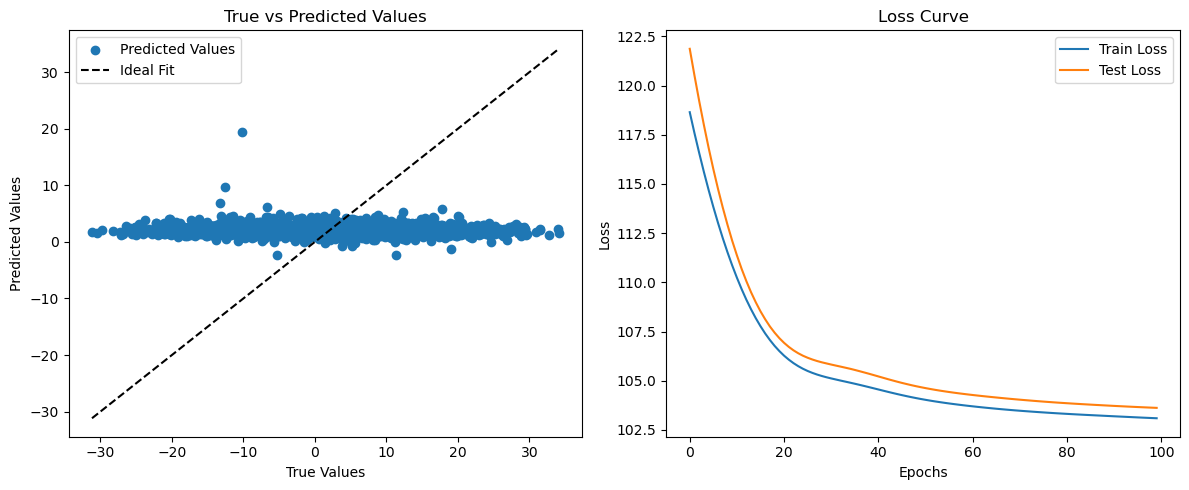

In [32]:
# Load the dataset and split it
X_train, X_test, y_train, y_test = load_california_housing()

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

# Add noise to the training and test labels
y_train_noisy = add_noise(y_train, noise_level=10).astype(np.float32)
y_test_noisy = add_noise(y_test, noise_level=10).astype(np.float32)

# Train the initial model
model = create_model(input_dim=X_train.shape[1], hidden_units=[10])
train_loss_history, test_loss_history = train_model(model, X_train, y_train_noisy, X_test, y_test_noisy)
y_pred = forward_pass(model, X_test).numpy()
plot_results(y_test_noisy, y_pred, train_loss_history, test_loss_history)

### Train a model after adding noisy and increasing complexity

Epoch 0: Train Loss = 3137.469482421875, Test Loss = 2914.395751953125
Epoch 10: Train Loss = 2711.049072265625, Test Loss = 2577.553466796875
Epoch 20: Train Loss = 2575.96533203125, Test Loss = 2496.74462890625
Epoch 30: Train Loss = 2528.924560546875, Test Loss = 2461.360107421875
Epoch 40: Train Loss = 2508.98486328125, Test Loss = 2438.224365234375
Epoch 50: Train Loss = 2499.52197265625, Test Loss = 2436.071533203125
Epoch 60: Train Loss = 2495.4111328125, Test Loss = 2431.017578125
Epoch 70: Train Loss = 2493.45361328125, Test Loss = 2428.907958984375
Epoch 80: Train Loss = 2492.362548828125, Test Loss = 2429.468017578125
Epoch 90: Train Loss = 2491.70654296875, Test Loss = 2428.298095703125


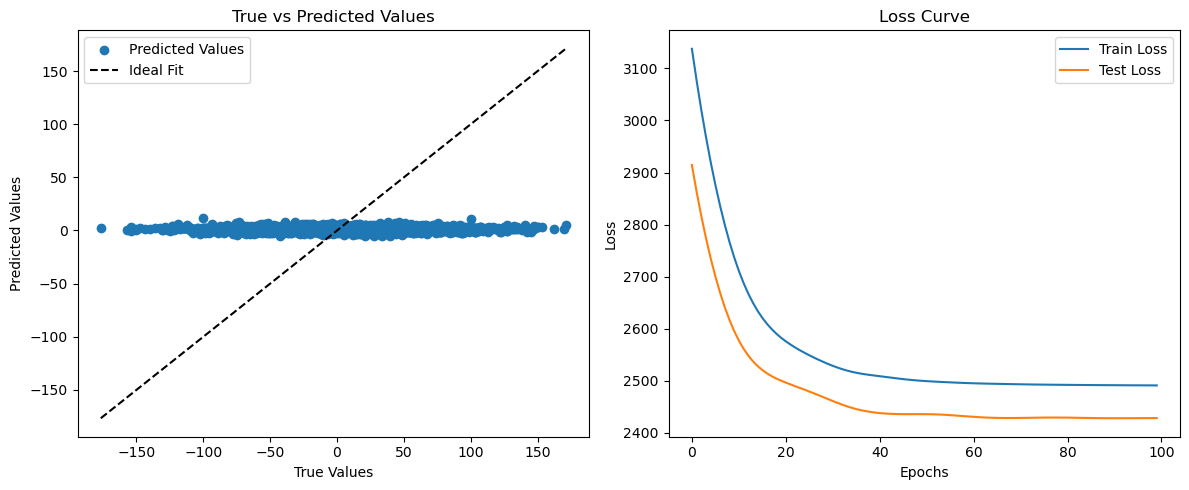

In [33]:
# Add more noise to the training and test labels
y_train_noisy = add_noise(y_train, noise_level=50).astype(np.float32)
y_test_noisy = add_noise(y_test, noise_level=50).astype(np.float32)

# Train a more complex model
model = create_model(input_dim=X_train.shape[1], hidden_units=[10, 10])
train_loss_history, test_loss_history = train_model(model, X_train, y_train_noisy, X_test, y_test_noisy)
y_pred = forward_pass(model, X_test).numpy()
plot_results(y_test_noisy, y_pred, train_loss_history, test_loss_history)

Initial Model:
* True vs Predicted Values: The scatter plot shows that the predicted values are spread around the true values but with significant deviations. The predicted values do not align well with the ideal fit line (the diagonal), indicating the model is not capturing the underlying patterns effectively.
* Loss Curve:Both the training loss and test loss decrease over epochs, indicating the model is learning.
The training loss is slightly lower than the test loss, suggesting that the model is generalizing relatively well but still underfits the data. The final loss values suggest that the model has not fully captured the complexity of the data.

Second Model:
* True vs Predicted Values: The scatter plot shows a wider range of predicted values compared to the true values, indicating increased noise and deviations. The predicted values are even more spread out, and the range is significantly larger, showing that the increased noise has made it harder for the model to capture the underlying patterns.
* Loss Curve: The training loss remains higher than the test loss throughout the epochs, which is unusual and indicates possible issues with the training data noise or the model's ability to learn from it. The test loss is lower, which may indicate that the test data has less noise or is easier to fit than the training data.Despite the model being more complex, the increased noise level has likely led to poorer learning performance overall.